In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import datetime
import torch
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [75]:
csv_file = './Option_SPX.csv'
data = pd.read_csv(csv_file)
print(data.shape)
data.dropna(inplace=True)
print(data.shape)
print(data.head())

feature_cols = ['Moneyness', 'TTM', 'D_BS']

X_train = data[feature_cols].iloc[0:30]
y_train = data['Target'].iloc[0:30]

X_test = data[feature_cols].iloc[30:35]
y_test = data['Target'].iloc[30:35]

print(f'\n\nFeatures:\n {X_train.describe()} \n test features: \n { X_test.describe()} \n\n Training target var data:\n {y_train.describe()}\n test target var data: {y_test.describe()}')

(1020, 14)
(1008, 14)
         Date  ID  Days until next hedge        S  Dividend        C_BS  \
0  2024/08/05   1                      1  5186.33    1.4816  125.615076   
1  2024/08/06   1                      1  5240.03    1.4665  120.416043   
2  2024/08/07   1                      1  5199.50    1.4786  106.223538   
3  2024/08/08   1                      1  5319.31    1.4450  139.557618   
4  2024/08/09   1                      3  5344.16    1.4383  134.699810   

       D_BS   C_mkt  D_Blm        R  TTM  Moneyness  D_Optimal  Residual  
0  0.308576  147.20  0.339  4.95853  228       -514  -0.398225 -0.706801  
1  0.317215  125.90  0.330  4.95203  227       -460   0.344879  0.027664  
2  0.291429  111.85  0.312  4.85962  226       -501   0.350350  0.058922  
3  0.357376  153.75  0.380  4.95040  225       -381  -0.332813 -0.690190  
4  0.362407  145.55  0.379  4.97276  224       -356   2.613517  2.251110  


Features:
         Moneyness         TTM       D_BS
count   30.000000   30.

In [76]:
def describe_data(df):
    print(df.describe())
    print("\nSkew: ")
    print(df.skew())
    print("\nKurtosis: ")
    print(df.kurtosis())
    for column in df.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df[column], kde=True)
        plt.title(f'Histogram and KDE for {column}')
        plt.show()

# describe_data(X)
# describe_data(y)

In [77]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [78]:
y_train.head()

0   -0.706801
1    0.027664
2    0.058922
3   -0.690190
4    2.251110
Name: Residual, dtype: float64

In [79]:
def plot_train_test(train, test):
    columns = train.columns.tolist()
    for column in columns:
        plt.hist(train[column], bins=30, alpha=0.5
                 , label=f'Training data for {column}')
        plt.hist(test[column], bins=30, alpha=0.5, label=f'Test data for {column}')
        plt.legend()
        plt.title(f'Distribution of {column}')
        plt.show()


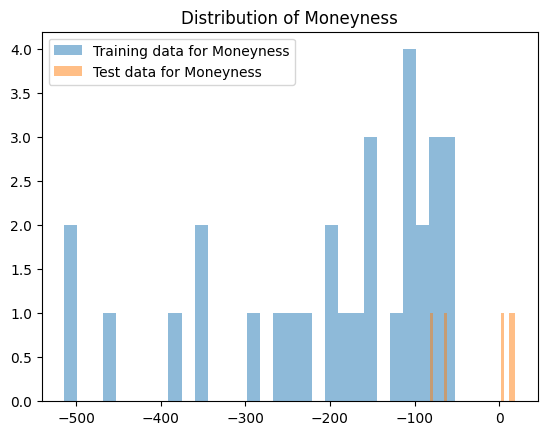

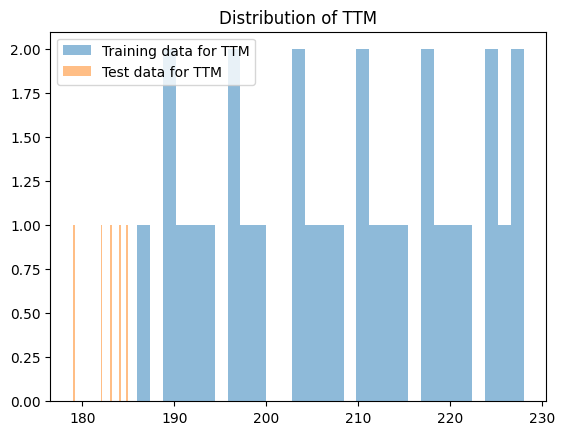

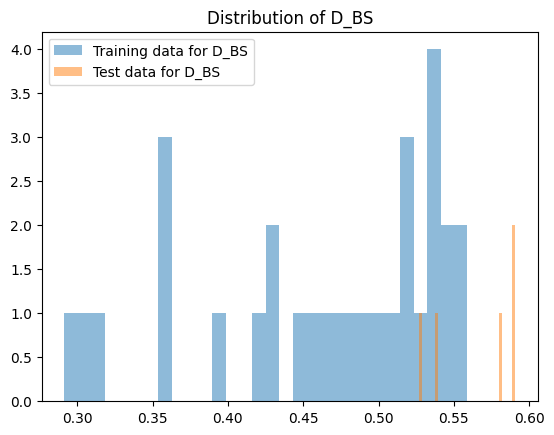

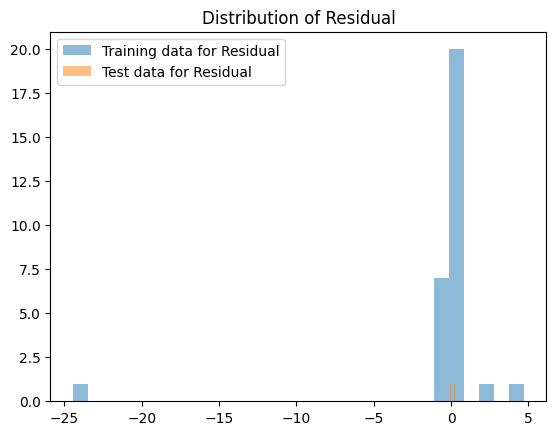

In [80]:
plot_train_test(X_train, X_test)
print("\n\n\n\n\n\n")


y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
plot_train_test(y_train, y_test)

In [81]:
scaler = MinMaxScaler()

datasets = {
    "X_train": X_train,
    "X_test": X_test,
}

for key in datasets:
    datasets[key] = scaler.fit_transform(datasets[key])

feat_cols = ['Moneyness', 'TTM', 'D_BS']
target_cols = ['Residual']

X_train = pd.DataFrame(datasets["X_train"], columns=feat_cols)
X_test = pd.DataFrame(datasets["X_test"], columns=feat_cols)

X_train.to_csv('./X_train.csv')
y_train.to_csv('./y_train.csv')
X_test.to_csv('./X_test.csv')
y_test.to_csv('./y_test.csv')

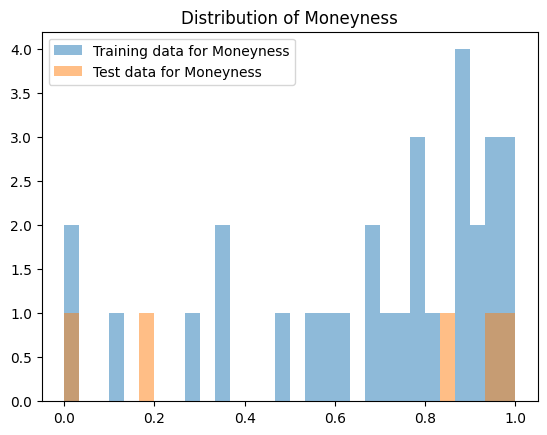

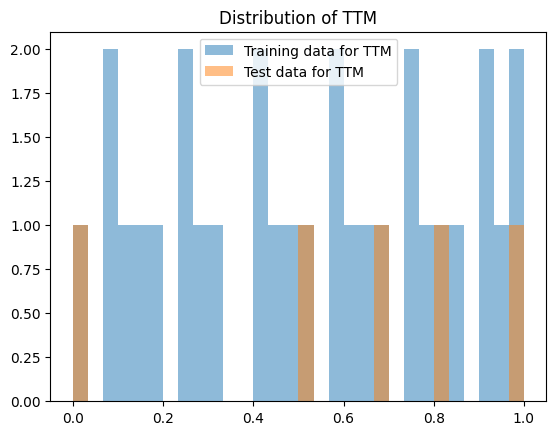

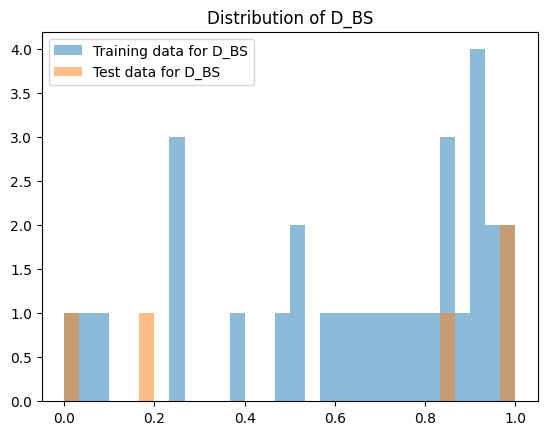

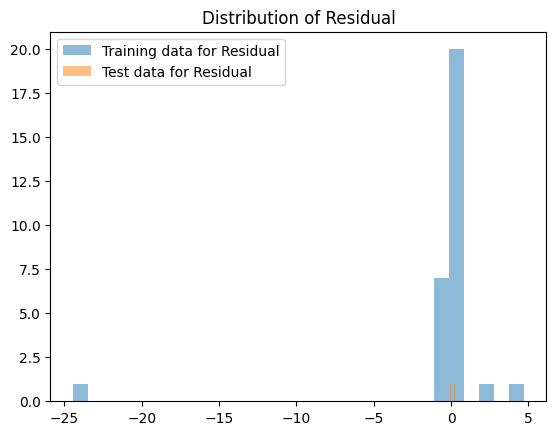

In [82]:
plot_train_test(X_train, X_test)
print("\n\n\n\n\n\n")
plot_train_test(y_train, y_test)

In [83]:
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

class FNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FNN, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)  # 3 to 6
        self.activation = nn.Sigmoid()
        self.output = nn.Linear(hidden_size, output_size)  # 6 to 1

    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x


input_size = 3
hidden_size = 6
output_size = 1

In [84]:
model = FNN(input_size, hidden_size, output_size)
loss_func = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

X_train = torch.tensor(X_train.values, dtype=torch.float)
X_test = torch.tensor(X_test.values, dtype=torch.float)

y_train = torch.tensor(y_train.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)

In [85]:
def train_model(model, epochs):
    patience = 5
    best_val_loss = float('inf')
    print("Initial model weights:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.data}")

    for epoch in range(epochs):

        model.train()

        # Forward pass
        predictions_train = model(X_train)
        loss_train = loss_func(predictions_train, y_train)

        # Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss_train.item():.4f}")

train_model(model, 2)

Initial model weights:
hidden.weight: tensor([[ 0.4414,  0.4792, -0.1353],
        [ 0.5304, -0.1265,  0.1165],
        [-0.2811,  0.3391,  0.5090],
        [-0.4236,  0.5018,  0.1081],
        [ 0.4266,  0.0782,  0.2784],
        [-0.0815,  0.4451,  0.0853]])
hidden.bias: tensor([-0.2695,  0.1472, -0.2660, -0.0677, -0.2345,  0.3830])
output.weight: tensor([[-0.3223, -0.1882, -0.1153, -0.2455,  0.0385, -0.4032]])
output.bias: tensor([0.3687])
Epoch [1/2], Training Loss: 20.5450
Initial model weights:
hidden.weight: tensor([[ 0.4419,  0.4795, -0.1348],
        [ 0.5306, -0.1264,  0.1168],
        [-0.2809,  0.3392,  0.5091],
        [-0.4232,  0.5020,  0.1085],
        [ 0.4265,  0.0782,  0.2783],
        [-0.0809,  0.4454,  0.0859]])
hidden.bias: tensor([-0.2691,  0.1474, -0.2658, -0.0673, -0.2345,  0.3835])
output.weight: tensor([[-0.3256, -0.1922, -0.1184, -0.2481,  0.0348, -0.4070]])
output.bias: tensor([0.3630])
Epoch [2/2], Training Loss: 20.5347


In [86]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = loss_func(predictions, y_test)
    
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.2414


In [87]:
# Initial model weights:
# hidden.weight: tensor
# ([[ 0.4414,  0.4792, -0.1353],
# [ 0.5304, -0.1265,  0.1165],
# [-0.2811,  0.3391,  0.5090],
# [-0.4236,  0.5018,  0.1081],
# [ 0.4266,  0.0782,  0.2784],
# [-0.0815,  0.4451,  0.0853]])

'\nInitial model weights:\nhidden.weight: tensor\n        ([[ 0.4414,  0.4792, -0.1353],\n        [ 0.5304, -0.1265,  0.1165],\n        [-0.2811,  0.3391,  0.5090],\n        [-0.4236,  0.5018,  0.1081],\n        [ 0.4266,  0.0782,  0.2784],\n        [-0.0815,  0.4451,  0.0853]])\n        '

In [88]:
        # Batch training code
        
        # for start in range(0, len(X_shuffled), batch_size):
        #     end = start + batch_size
        #     X_batch = X_shuffled[start:end]
        #     y_batch = y_shuffled[start:end]
            
        #     # Forward pass
        #     predictions_train = model(X_batch)
        #     loss_train = loss_func(predictions_train, y_batch)
            
        #     # Backward pass
        #     optimizer.zero_grad()
        #     loss_train.backward()
        #     optimizer.step()
    
        # model.eval()
        # with torch.no_grad():  # Don't calculate gradient while validating
        #     predictions_val = model(X_val)
        #     loss_val = loss_func(predictions_val, y_val)
    
        # # Check for improvement
        # if loss_val < best_val_loss:
        #     best_val_loss = loss_val
        #     wait = 0
        # else:
        #     wait += 1
        #     if wait >= patience:
        #         print("Early stoppage")
        #         print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}")
        #         break
                
        # if (epoch + 1) % 5 == 0:

In [89]:
        
        # indices = torch.randperm(len(X_train))
        # X_shuffled = X_train[indices]
        # y_shuffled = y_train[indices]
        
        # print(f"Manually Shuffled Features Tensor: {X_shuffled}")
        # print(f"Manually Shuffled Target Tensor: {y_shuffled}")